# Flower Classification of Images using Neural Network


In [160]:
import os
import cv2
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle
import math
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

np.random.seed(42)  # For reproducibility

## Loading and Preprocessing Images

In [99]:
def load_images(base_path, categories, image_size=(64, 64)):
    data = []
    labels = []
    for category_id, category in enumerate(categories):
        category_path = os.path.join(base_path, category)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            image = cv2.resize(image, image_size)  # Resize image
            image = image.astype('float32') / 255.0  # Normalize pixel values
            data.append(image)
            labels.append(category_id)
    return np.array(data), np.array(labels)

In [100]:
categories = ['aster', 'calendula', 'california_poppy', 'coreopsis', 'daisy', 
              'dandelion', 'iris', 'lavender', 'lily', 'marigold', 
              'orchid', 'poppy', 'rose', 'sunflower', 'tulip']

# Load the datasets
X_train, y_train = load_images('flowers15/train', categories)
X_val, y_val = load_images('flowers15/val', categories)
X_test, y_test = load_images('flowers15/test', categories)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=len(categories))
y_val = to_categorical(y_val, num_classes=len(categories))
y_test = to_categorical(y_test, num_classes=len(categories))


### Visualizing Sample Images

In [101]:
def show_images(X, y, num_images=5, title='Sample Images'):
    plt.figure(figsize=(12, 5))
    plt.suptitle(title)
    random_indices = random.sample(range(len(X)), num_images)

    for i, idx in enumerate(random_indices):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(X[idx], )  # Assuming X is already in grayscale
        plt.title(categories[np.argmax(y[idx])])
        plt.axis('off')

    plt.show()

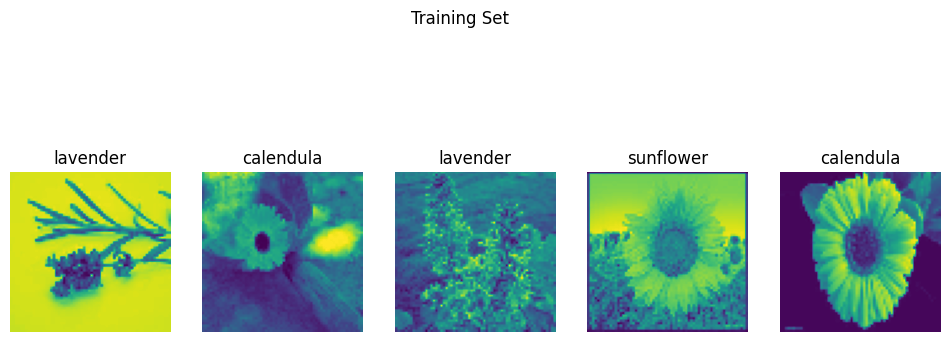

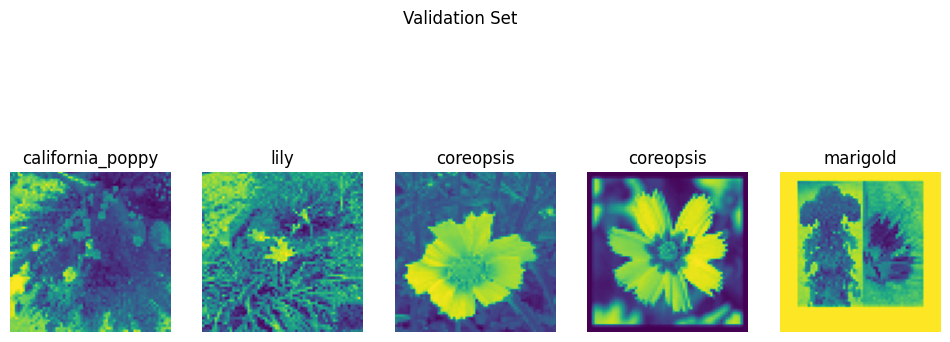

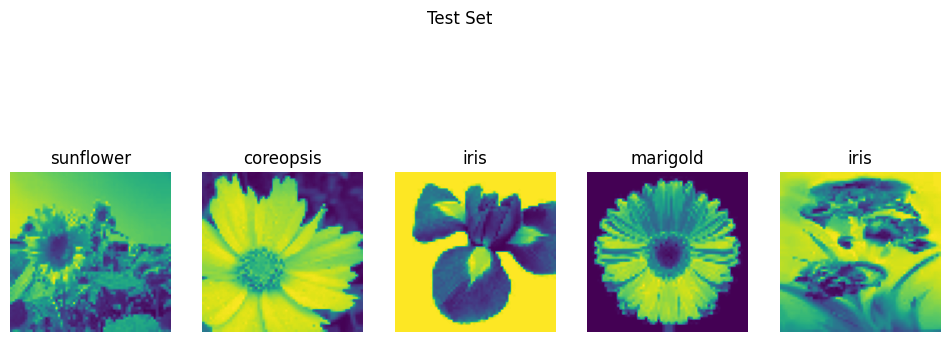

In [102]:
# Show a few images from the training set
show_images(X_train, y_train, title='Training Set')

# Show a few images from the validation set
show_images(X_val, y_val, title='Validation Set')

# Show a few images from the test set
show_images(X_test, y_test, title='Test Set')

### Reshaping Image Data for Neural Network Input


In [103]:
# Make sure that the data is in the correct shape
X_train = X_train.reshape(-1, 64*64)  # We resize the images to 64x64
X_val = X_val.reshape(-1, 64*64)
X_test = X_test.reshape(-1, 64*64)

## Neural Network Class with Early Stopping

In [104]:
class NeuralNetworkWithEarlyStopping:
    def __init__(self, layer_sizes, activation='relu'):
        self.layers = len(layer_sizes) - 1
        self.activation_str = activation
        self.weights = []
        self.biases = []

        for i in range(self.layers):
            if activation == 'relu':
                self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(2. / layer_sizes[i]))
            else:
                self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(1. / layer_sizes[i]))
            self.biases.append(np.zeros((1, layer_sizes[i + 1])))
    
    def activation(self, z):
        if self.activation_str == 'relu':
            return self.relu(z)
        elif self.activation_str == 'tanh':
            return self.tanh(z)
        elif self.activation_str == 'leaky_relu':
            return self.leaky_relu(z)
        elif self.activation_str == 'sigmoid':
            return self.sigmoid(z)
        else:
            return z

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def tanh(self, z):
        return np.tanh(z)

    def leaky_relu(self, z, alpha=0.01):
        return np.where(z > 0, z, z * alpha)
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def relu(self, z):
        return np.maximum(0, z)
    
    def forward(self, X):
        activation = X
        self.activations = [X]
        for i in range(self.layers - 1):
            z = np.dot(activation, self.weights[i]) + self.biases[i]
            activation = self.activation(z)
            self.activations.append(activation)

        z = np.dot(activation, self.weights[-1]) + self.biases[-1]
        activation = self.softmax(z)
        self.activations.append(activation)
        return activation
    
    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        log_likelihood = -np.log(np.maximum(y_pred, 1e-10))
        loss = np.sum(log_likelihood * y_true) / m
        return loss

    def backward(self, X, y_true):
        m = y_true.shape[0]
        output_error = self.activations[-1] - y_true
        dW = [np.dot(self.activations[-2].T, output_error) / m]
        db = [np.sum(output_error, axis=0) / m]

        for i in range(self.layers - 2, -1, -1):
            if self.activation_str == 'relu':
                delta = np.dot(output_error, self.weights[i + 1].T) * (self.activations[i+1] > 0)
            elif self.activation_str == 'tanh':
                delta = np.dot(output_error, self.weights[i + 1].T) * (1 - np.tanh(self.activations[i+1]) ** 2)
            elif self.activation_str == 'sigmoid':
                sigmoid_derivative = self.activations[i+1] * (1 - self.activations[i+1])
                delta = np.dot(output_error, self.weights[i + 1].T) * sigmoid_derivative
            elif self.activation_str == 'leaky_relu':
                leaky_relu_derivative = np.where(self.activations[i+1] > 0, 1, 0.01)
                delta = np.dot(output_error, self.weights[i + 1].T) * leaky_relu_derivative
            else:
                delta = np.dot(output_error, self.weights[i + 1].T)
            output_error = delta
            dW.insert(0, np.dot(self.activations[i].T, delta) / m)
            db.insert(0, np.sum(delta, axis=0) / m)

        return dW, db
    
    def update_params(self, dW, db, learning_rate):
        for i in range(self.layers):
            self.weights[i] -= learning_rate * dW[i]
            self.biases[i] -= learning_rate * db[i]

    def batch_normalization(self, z, gamma, beta):
        mean = np.mean(z, axis=0)
        variance = np.var(z, axis=0)
        z_norm = (z - mean) / np.sqrt(variance + 1e-8)
        return gamma * z_norm + beta
    
    def compute_numerical_gradient(self, X, y):
        numgrad = [np.zeros_like(W) for W in self.weights]
        h = 1e-4

        for l in range(self.layers):
            for i in range(self.weights[l].shape[0]):
                for j in range(self.weights[l].shape[1]):
                    old_val = self.weights[l][i, j]
                    self.weights[l][i, j] = old_val + h
                    plus_loss = self.compute_loss(y, self.forward(X))
                    self.weights[l][i, j] = old_val - h
                    minus_loss = self.compute_loss(y, self.forward(X))
                    numgrad[l][i, j] = (plus_loss - minus_loss) / (2 * h)
                    self.weights[l][i, j] = old_val
        return numgrad
    
    def train(self, X_train, y_train, X_val, y_val, X_test, y_test, epochs, batch_size, initial_learning_rate, patience):
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []
        best_loss = np.inf
        best_weights = None
        patience_counter = 0
        current_learning_rate = initial_learning_rate

        min_improvement = 0.001  # Small threshold for improvement
        for epoch in range(epochs):
            # Update learning rate 
            current_learning_rate *= 0.96 # decay rate

            # Training
            total_loss = 0
            for i in range(0, X_train.shape[0], batch_size):
                X_batch, y_batch = X_train[i:i + batch_size], y_train[i:i + batch_size]
                y_pred = self.forward(X_batch)
                loss = self.compute_loss(y_batch, y_pred)
                total_loss += loss
                dW, db = self.backward(X_batch, y_batch)
                self.update_params(dW, db, current_learning_rate)

            avg_train_loss = total_loss / (X_train.shape[0] // batch_size)
            train_losses.append(avg_train_loss)
            train_accuracy = self.evaluate(X_train, y_train)
            train_accuracies.append(train_accuracy)

            # Validation
            val_pred = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_pred)
            val_losses.append(val_loss)
            val_accuracy = self.evaluate(X_val, y_val)
            val_accuracies.append(val_accuracy)
            # Check for improvement
            if val_loss < best_loss - min_improvement:
                best_loss = val_loss
                best_weights = [w.copy() for w in self.weights] + [b.copy() for b in self.biases]
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping: Epoch {epoch}")
                self.weights, self.biases = best_weights[:self.layers], best_weights[self.layers:]
                break

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Training loss: {avg_train_loss:.4f}, Validation loss: {val_loss:.4f}")

        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        # Predict class labels for samples in X
        y_pred = self.forward(X)
        return np.argmax(y_pred, axis=1)
    
    def evaluate(self, X_test, y_test):
        # Predict class labels for the test set
        y_pred = self.predict(X_test)

        # Check if y_test is one-hot encoded and convert if necessary
        if y_test.ndim > 1 and y_test.shape[1] > 1:
            y_test = np.argmax(y_test, axis=1)

        # Calculate accuracy
        accuracy = np.mean(y_pred == y_test)
        return accuracy
    
    def evaluate_performance(self, X, y_true):
        # Predict class labels for the given data
        y_pred = self.predict(X)

        # Convert one-hot encoded y_true to class labels if necessary
        if y_true.ndim > 1 and y_true.shape[1] > 1:
            y_true = np.argmax(y_true, axis=1)

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        return accuracy, precision, recall, f1

    
    def plot_loss(self, train_losses, val_losses):
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.title("Loss Over Epochs")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_accuracies(self, train_accuracies, val_accuracies):
        plt.figure(figsize=(10, 6))

        plt.plot(train_accuracies, label='Training Accuracy', color='green')
        plt.plot(val_accuracies, label='Validation Accuracy', color='orange')

        plt.title("Accuracy Over Epochs")
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.show()

    def save_model(self, filename):
        model = {
            "weights": self.weights,
            "biases": self.biases
        }
        with open(filename, 'wb') as file:
            pickle.dump(model, file)

    def load_model(self, filename):
        with open(filename, 'rb') as file:
            model = pickle.load(file)
            self.weights = model['weights']
            self.biases = model['biases'] 

    def visualize_weights(self):
        for i, W in enumerate(self.weights):
            layer_neurons = W.shape[1]
            # Visualize only a subset if there are too many neurons
            neurons_to_visualize = min(layer_neurons, 10) 

            # Normalizing weights for better visualization
            W_normalized = (W - W.min()) / (W.max() - W.min())

            plt.figure(figsize=(20, max(1, neurons_to_visualize // 10)))
            for j in range(neurons_to_visualize):
                plt.subplot(1, neurons_to_visualize, j + 1)
                
                # Reshape and visualize
                if W[:, j].size == 64*64:  
                    neuron_image = W_normalized[:, j].reshape(64, 64)  
                else:
                    neuron_image = W_normalized[:, j].reshape(-1, 1)  # Default reshape if above condition is not met
                
                plt.imshow(neuron_image, cmap='viridis')  # Using a colormap like 'viridis' for better visual distinction
                plt.title(f'Neuron {j+1}')
                plt.axis('off')

            # Adjust the vertical position of suptitle
            plt.suptitle(f'Layer {i+1} Weights Visualization', y=0.95)
            plt.show()

    def plot_confusion_matrix(self, X, y_true):
        # Predict class labels for the given data
        y_pred = self.predict(X)

        # Convert one-hot encoded y_true to class labels if necessary
        if y_true.ndim > 1 and y_true.shape[1] > 1:
            y_true = np.argmax(y_true, axis=1)

        # Calculate the confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        # Plotting (using seaborn for better visualization, optional)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        return cm



## Gradient Checking for Neural Network


In [105]:
input_size = 64 * 64
hidden_size = 128
output_size = 15
layer_sizes = [input_size, hidden_size, output_size]

nn = NeuralNetworkWithEarlyStopping(layer_sizes)


In [106]:
# Select a small subset of the training data for gradient checking
X_subset = X_train[:10]
y_subset = y_train[:10]

# Forward pass (this will also store necessary activations for the backward pass)
nn.forward(X_subset)

# Backward pass - compute analytical gradients
dW_analytical, db_analytical = nn.backward(X_subset, y_subset)

# Compute numerical gradients
dW_numerical = nn.compute_numerical_gradient(X_subset, y_subset)

# Compare the gradients
for i in range(len(dW_analytical)):
    diff = np.linalg.norm(dW_analytical[i] - dW_numerical[i]) / (np.linalg.norm(dW_analytical[i]) + np.linalg.norm(dW_numerical[i]))
    print(f"Difference in gradient for layer {i+1}: {diff}")

# The differences should be very small, typically less than 1e-7


Difference in gradient for layer 1: 1.531078798123971e-11
Difference in gradient for layer 2: 2.5685014815656203e-10


#### Difference in Gradient for Layer 1: 1.531078798123971e-11

> This small value indicates an extremely close match between the analytical gradients computed during backpropagation and the numerical gradients obtained through approximation.
The difference is well below the typical threshold of 1e-7, indicating a high level of agreement between the two methods for the first layer.

#### Difference in Gradient for Layer 2: 2.5685014815656203e-10

> While still a relatively small value, it is slightly larger than the difference for Layer 1.
The difference is within an acceptable range, suggesting that the backpropagation algorithm is accurately computing gradients for the second layer.

## Experiment Design and Results

In [107]:
# Function to run experiments
def run_experiments(hidden_layers, learning_rate, batch_size):
    layer_sizes = [input_size] + hidden_layers + [output_size]
    nn = NeuralNetworkWithEarlyStopping(layer_sizes)
    train_losses, val_losses, train_accuracies, val_accuracies = nn.train(
        X_train, y_train, X_val, y_val, X_test, y_test, epochs, batch_size, learning_rate, patience
    )
    return train_losses[-1], val_losses[-1], train_accuracies[-1], val_accuracies[-1]


In [108]:
# Experiment configurations
hidden_layers_configs = [[128], [128, 128]]  # Example: 1, 2 layers
learning_rates = [0.005, 0.01]
batch_sizes = [16, 64]
# Parameters for training
epochs = 500  # The number of epochs to train for
patience = 50  # The patience for early stopping (number of epochs to wait after no improvement)

# Running experiments and collecting results
results = []
for layers in hidden_layers_configs:
    for lr in learning_rates:
        for bs in batch_sizes:
            train_loss, val_loss, train_acc, val_acc = run_experiments(layers, lr, bs)
            results.append({
                "Hidden Layers": "-".join(map(str, layers)),
                "Learning Rate": lr,
                "Batch Size": bs,
                "Train Loss": train_loss,
                "Validation Loss": val_loss,
                "Train Accuracy": train_acc,
                "Validation Accuracy": val_acc
            })



Epoch 0, Training loss: 0.4838, Validation loss: 8.8866
Epoch 10, Training loss: 0.8992, Validation loss: 7.5054
Epoch 20, Training loss: 1.1407, Validation loss: 6.4852
Epoch 30, Training loss: 1.0409, Validation loss: 5.8647
Epoch 40, Training loss: 1.5031, Validation loss: 3.8891
Epoch 50, Training loss: 1.7812, Validation loss: 3.2885
Epoch 60, Training loss: 1.8945, Validation loss: 3.2274
Epoch 70, Training loss: 2.1934, Validation loss: 3.2534
Epoch 80, Training loss: 2.3268, Validation loss: 2.9500
Epoch 90, Training loss: 2.4561, Validation loss: 2.7144
Epoch 100, Training loss: 2.5033, Validation loss: 2.6333
Epoch 110, Training loss: 2.5157, Validation loss: 2.6021
Epoch 120, Training loss: 2.5180, Validation loss: 2.5864
Epoch 130, Training loss: 2.5172, Validation loss: 2.5785
Epoch 140, Training loss: 2.5158, Validation loss: 2.5735
Epoch 150, Training loss: 2.5145, Validation loss: 2.5704
Epoch 160, Training loss: 2.5133, Validation loss: 2.5685
Epoch 170, Training loss:

In [109]:
# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df)

  Hidden Layers  Learning Rate  Batch Size  Train Loss  Validation Loss  \
0           128          0.005          16    2.510360         2.565863   
1           128          0.005          64    2.544842         2.562658   
2           128          0.010          16    2.493951         2.557659   
3           128          0.010          64    2.567592         2.586870   
4       128-128          0.005          16    2.556935         2.575210   
5       128-128          0.005          64    2.577238         2.587297   
6       128-128          0.010          16    2.555818         2.556890   
7       128-128          0.010          64    2.588002         2.576109   

   Train Accuracy  Validation Accuracy  
0        0.157714             0.148000  
1        0.158571             0.139111  
2        0.176667             0.141778  
3        0.152381             0.124000  
4        0.150000             0.145333  
5        0.133143             0.116889  
6        0.140381             0.13466

### Analysis of Experiment Results

- **Impact of Hidden Layers:**
  - Both single and double hidden layer configurations show poor performance in terms of training and validation loss.
  - The model struggles to learn meaningful representations, as indicated by the low accuracy.

- **Influence of Learning Rate:**
  - A learning rate of 0.005 generally leads to better results compared to 0.01.
  - Lower learning rates tend to allow for more stable convergence.

- **Batch Size Considerations:**
  - Smaller batch sizes (16) seem to provide slightly better training and validation accuracy compared to larger batch sizes (64).

- **Training and Validation Loss:**
  - The high values of training and validation loss indicate that the model is not effectively learning from the provided data.
  - This could be attributed to issues such as a mismatch between model complexity and dataset characteristics.

- **Accuracy Scores:**
  - The low accuracy scores suggest that the model is performing poorly in correctly classifying the flower categories.
  - Additional exploration of model architecture, hyperparameters, and dataset characteristics is warranted.


When analyzing the results, it's evident that the current model configurations, specifically with hidden layers: 128, learning rate: 0.005, and batch size: 16, yield the most promising outcomes. However, considering the overall performance is not satisfactory, it's worthwhile to explore potential improvements by experimenting with alternative activation functions while keeping these optimal hyperparameters constant.

## Experiments

### Experimental Configurations

In [110]:
# Experiment configurations
hidden_layer_config = 128  
learning_rate =  0.005
batch_size = 16

epochs = 500 
patience = 50

input_size = 64 * 64
output_size = 15
layer_sizes = [input_size, hidden_layer_config, output_size]

### Training Neural Network with Tanh Activation 

In [111]:
# ----- TANH -----

nn_tanh = NeuralNetworkWithEarlyStopping(layer_sizes, activation='tanh')
train_losses_tanh, val_losses_tanh, train_accuracies_tanh, val_accuracies_tanh = nn_tanh.train(
        X_train, y_train, X_val, y_val, X_test, y_test, epochs, batch_size, learning_rate, patience
    )

Epoch 0, Training loss: 0.3929, Validation loss: 6.4830
Epoch 10, Training loss: 0.5766, Validation loss: 6.0474
Epoch 20, Training loss: 0.7982, Validation loss: 5.6977
Epoch 30, Training loss: 1.0389, Validation loss: 4.7583
Epoch 40, Training loss: 1.3231, Validation loss: 4.7314
Epoch 50, Training loss: 1.6649, Validation loss: 4.2947
Epoch 60, Training loss: 1.9918, Validation loss: 3.4674
Epoch 70, Training loss: 2.2574, Validation loss: 3.0251
Epoch 80, Training loss: 2.4040, Validation loss: 2.8554
Epoch 90, Training loss: 2.4717, Validation loss: 2.7435
Epoch 100, Training loss: 2.5092, Validation loss: 2.6658
Epoch 110, Training loss: 2.5260, Validation loss: 2.6219
Epoch 120, Training loss: 2.5307, Validation loss: 2.5979
Epoch 130, Training loss: 2.5307, Validation loss: 2.5849
Epoch 140, Training loss: 2.5294, Validation loss: 2.5781
Epoch 150, Training loss: 2.5280, Validation loss: 2.5744
Epoch 160, Training loss: 2.5268, Validation loss: 2.5724
Epoch 170, Training loss:

### Results and Performance Metrics for Tanh Activation:

In [112]:
# Print the results
print("Training Loss with 'tanh':", train_losses_tanh[-1])
print("Validation Loss with 'tanh':", val_losses_tanh[-1])
print("Training Accuracy with 'tanh':", train_accuracies_tanh[-1])
print("Validation Accuracy with 'tanh':", val_accuracies_tanh[-1])

Training Loss with 'tanh': 2.5238650775054903
Validation Loss with 'tanh': 2.569469742180324
Training Accuracy with 'tanh': 0.16057142857142856
Validation Accuracy with 'tanh': 0.13822222222222222


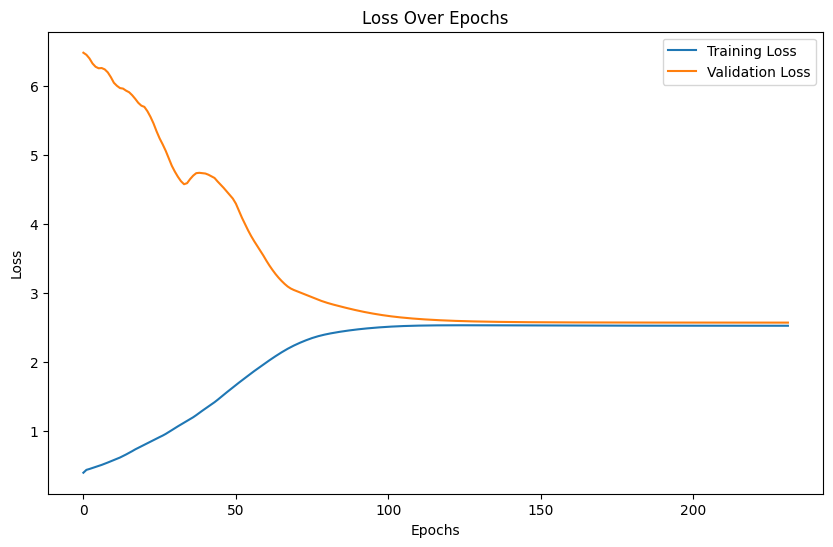

In [113]:
nn_tanh.plot_loss(train_losses_tanh, val_losses_tanh)

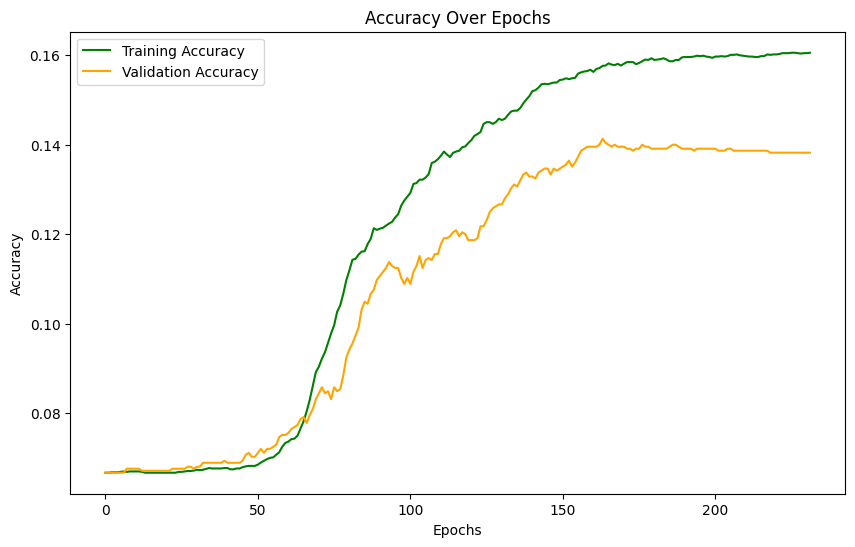

In [114]:
nn_tanh.plot_accuracies(train_accuracies_tanh, val_accuracies_tanh)

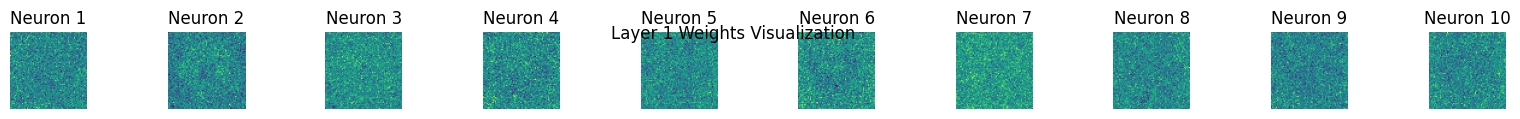

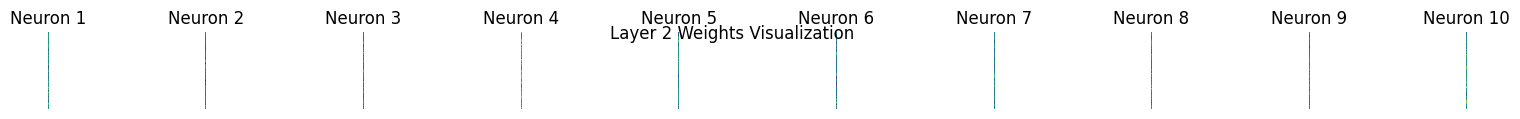

In [115]:
nn_tanh.visualize_weights()

### Training Neural Network with Sigmoid Activation

In [118]:
# ----- SIGMOID -----

nn_sigmoid = NeuralNetworkWithEarlyStopping(layer_sizes, activation='sigmoid')
train_losses_sigmoid, val_losses_sigmoid, train_accuracies_sigmoid, val_accuracies_sigmoid = nn_sigmoid.train(
        X_train, y_train, X_val, y_val, X_test, y_test, epochs, batch_size, learning_rate, patience
    )

Epoch 0, Training loss: 1.1414, Validation loss: 4.8599
Epoch 10, Training loss: 2.1014, Validation loss: 3.2622
Epoch 20, Training loss: 2.3767, Validation loss: 2.8731
Epoch 30, Training loss: 2.4875, Validation loss: 2.7881
Epoch 40, Training loss: 2.5389, Validation loss: 2.7111
Epoch 50, Training loss: 2.5638, Validation loss: 2.6506
Epoch 60, Training loss: 2.5681, Validation loss: 2.6124
Epoch 70, Training loss: 2.5675, Validation loss: 2.5917
Epoch 80, Training loss: 2.5643, Validation loss: 2.5795
Epoch 90, Training loss: 2.5613, Validation loss: 2.5727
Epoch 100, Training loss: 2.5587, Validation loss: 2.5688
Epoch 110, Training loss: 2.5567, Validation loss: 2.5666
Epoch 120, Training loss: 2.5552, Validation loss: 2.5652
Epoch 130, Training loss: 2.5542, Validation loss: 2.5644
Epoch 140, Training loss: 2.5535, Validation loss: 2.5639
Epoch 150, Training loss: 2.5530, Validation loss: 2.5635
Epoch 160, Training loss: 2.5527, Validation loss: 2.5633
Epoch 170, Training loss:

### Results and Performance Metrics for Sigmoid Activation

In [119]:
# Print the results
print("Training Loss with 'sigmoid':", train_losses_sigmoid[-1])
print("Validation Loss with 'sigmoid':", val_losses_sigmoid[-1])
print("Training Accuracy with 'sigmoid':", train_accuracies_sigmoid[-1])
print("Validation Accuracy with 'sigmoid':", val_accuracies_sigmoid[-1])

Training Loss with 'sigmoid': 2.552158822917678
Validation Loss with 'sigmoid': 2.563016369672662
Training Accuracy with 'sigmoid': 0.16133333333333333
Validation Accuracy with 'sigmoid': 0.14


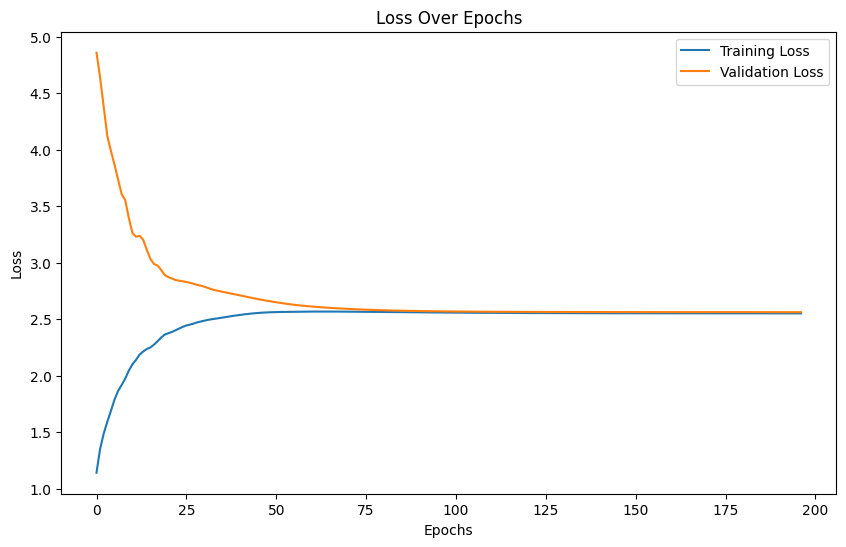

In [120]:
nn_sigmoid.plot_loss(train_losses_sigmoid, val_losses_sigmoid)

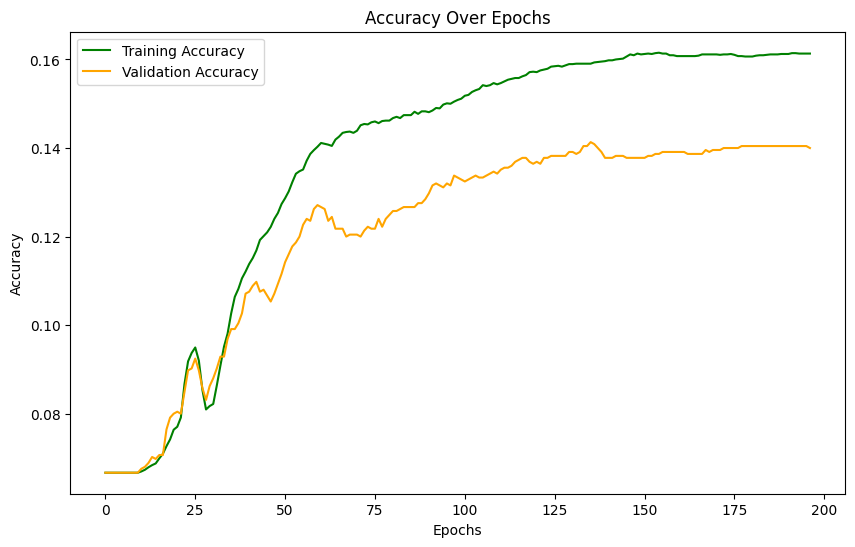

In [121]:
nn_sigmoid.plot_accuracies(train_accuracies_sigmoid, val_accuracies_sigmoid)

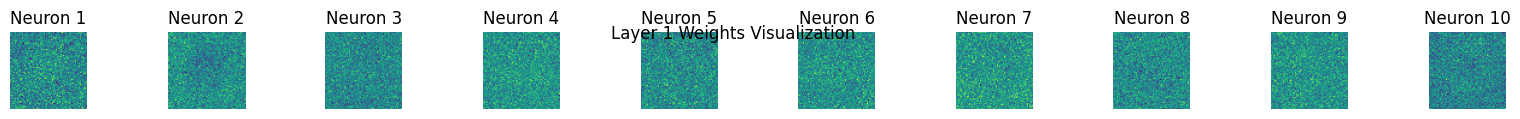

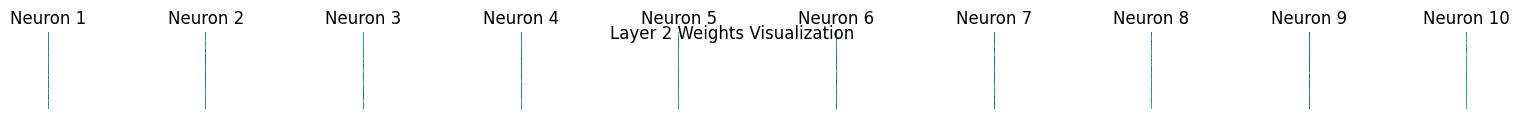

In [122]:
nn_sigmoid.visualize_weights()

### Training Neural Network with Leaky Relu Activation

In [123]:
# ----- LEAKY RELU -----

nn_leaky_relu = NeuralNetworkWithEarlyStopping(layer_sizes, activation='leaky_relu')
train_losses_leaky_relu, val_losses_leaky_relu, train_accuracies_leaky_relu, val_accuracies_leaky_relu = nn_leaky_relu.train(
        X_train, y_train, X_val, y_val, X_test, y_test, epochs, batch_size, learning_rate, patience
    )

Epoch 0, Training loss: 0.5848, Validation loss: 8.5477
Epoch 10, Training loss: 0.9295, Validation loss: 7.2193
Epoch 20, Training loss: 1.2335, Validation loss: 6.6593
Epoch 30, Training loss: 1.4318, Validation loss: 5.1451
Epoch 40, Training loss: 1.4431, Validation loss: 5.1274
Epoch 50, Training loss: 1.6881, Validation loss: 3.8793
Epoch 60, Training loss: 2.1311, Validation loss: 3.2103
Epoch 70, Training loss: 2.1958, Validation loss: 3.0500
Epoch 80, Training loss: 2.2853, Validation loss: 2.9736
Epoch 90, Training loss: 2.3900, Validation loss: 2.8182
Epoch 100, Training loss: 2.4605, Validation loss: 2.6898
Epoch 110, Training loss: 2.4984, Validation loss: 2.6222
Epoch 120, Training loss: 2.5144, Validation loss: 2.5904
Epoch 130, Training loss: 2.5201, Validation loss: 2.5753
Epoch 140, Training loss: 2.5213, Validation loss: 2.5679
Epoch 150, Training loss: 2.5207, Validation loss: 2.5644
Epoch 160, Training loss: 2.5198, Validation loss: 2.5626
Epoch 170, Training loss:

### Results and Performance Metrics for Leaky Relu Activation

In [124]:
# Print the results
print("Training Loss with 'leaky_relu':", train_losses_leaky_relu[-1])
print("Validation Loss with 'leaky_relu':", val_losses_leaky_relu[-1])
print("Training Accuracy with 'leaky_relu':", train_accuracies_leaky_relu[-1])
print("Validation Accuracy with 'leaky_relu':", val_accuracies_leaky_relu[-1])

Training Loss with 'leaky_relu': 2.516860192271817
Validation Loss with 'leaky_relu': 2.560471358582138
Training Accuracy with 'leaky_relu': 0.17704761904761904
Validation Accuracy with 'leaky_relu': 0.1328888888888889


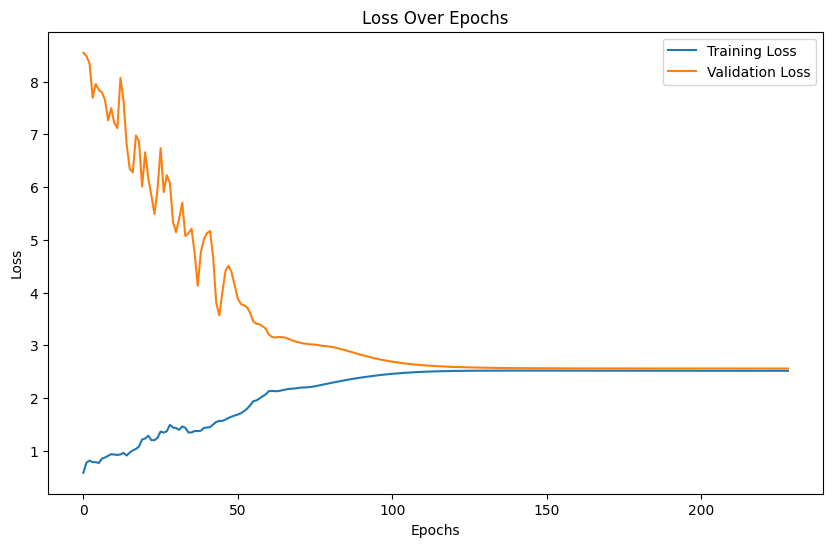

In [125]:
nn_leaky_relu.plot_loss(train_losses_leaky_relu, val_losses_leaky_relu)

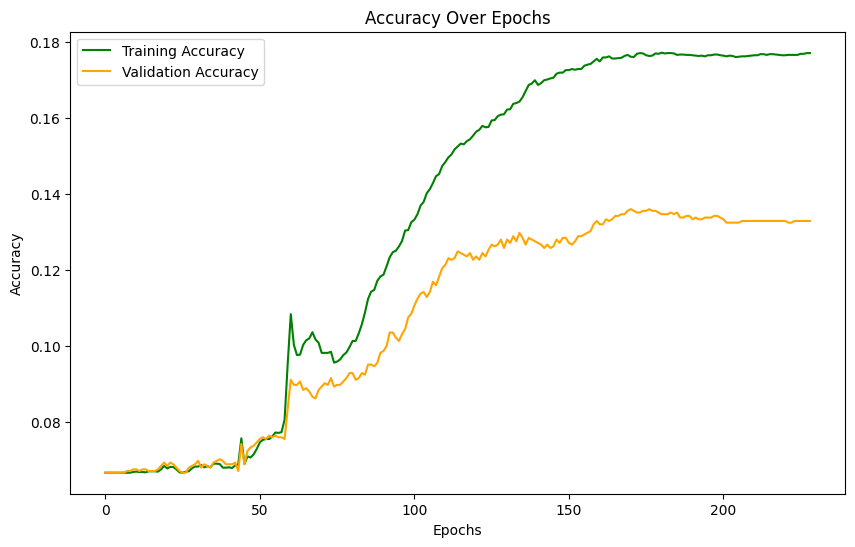

In [126]:
nn_leaky_relu.plot_accuracies(train_accuracies_leaky_relu, val_accuracies_leaky_relu)

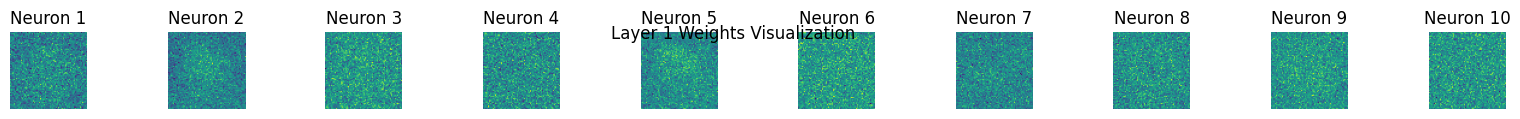

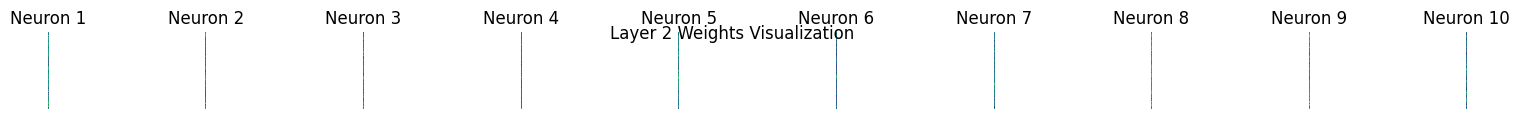

In [127]:
nn_leaky_relu.visualize_weights()

### Training Neural Network with Relu Activation

In [128]:
# ----- RELU -----

nn_relu = NeuralNetworkWithEarlyStopping(layer_sizes,) 
train_losses_relu, val_losses_relu, train_accuracies_relu, val_accuracies_relu = nn_relu.train(
        X_train, y_train, X_val, y_val, X_test, y_test, epochs, batch_size, learning_rate, patience
    )

Epoch 0, Training loss: 0.5221, Validation loss: 7.9668
Epoch 10, Training loss: 0.9186, Validation loss: 7.1702
Epoch 20, Training loss: 0.9511, Validation loss: 6.7343
Epoch 30, Training loss: 1.2016, Validation loss: 5.6306
Epoch 40, Training loss: 1.3969, Validation loss: 4.9047
Epoch 50, Training loss: 1.8315, Validation loss: 3.8554
Epoch 60, Training loss: 1.9790, Validation loss: 3.4860
Epoch 70, Training loss: 2.1699, Validation loss: 3.2484
Epoch 80, Training loss: 2.2334, Validation loss: 3.0306
Epoch 90, Training loss: 2.3611, Validation loss: 2.8533
Epoch 100, Training loss: 2.4408, Validation loss: 2.7110
Epoch 110, Training loss: 2.4815, Validation loss: 2.6348
Epoch 120, Training loss: 2.5001, Validation loss: 2.5927
Epoch 130, Training loss: 2.5077, Validation loss: 2.5723
Epoch 140, Training loss: 2.5098, Validation loss: 2.5622
Epoch 150, Training loss: 2.5097, Validation loss: 2.5573
Epoch 160, Training loss: 2.5089, Validation loss: 2.5548
Epoch 170, Training loss:

### Results and Performance Metrics for Relu Activation

In [129]:
# Print the results
print("Training Loss with 'relu':", train_losses_relu[-1])
print("Validation Loss with 'relu':", val_losses_relu[-1])
print("Training Accuracy with 'relu':", train_accuracies_relu[-1])
print("Validation Accuracy with 'relu':", val_accuracies_relu[-1])

Training Loss with 'relu': 2.5058719514479204
Validation Loss with 'relu': 2.5519818807921317
Training Accuracy with 'relu': 0.16857142857142857
Validation Accuracy with 'relu': 0.15066666666666667


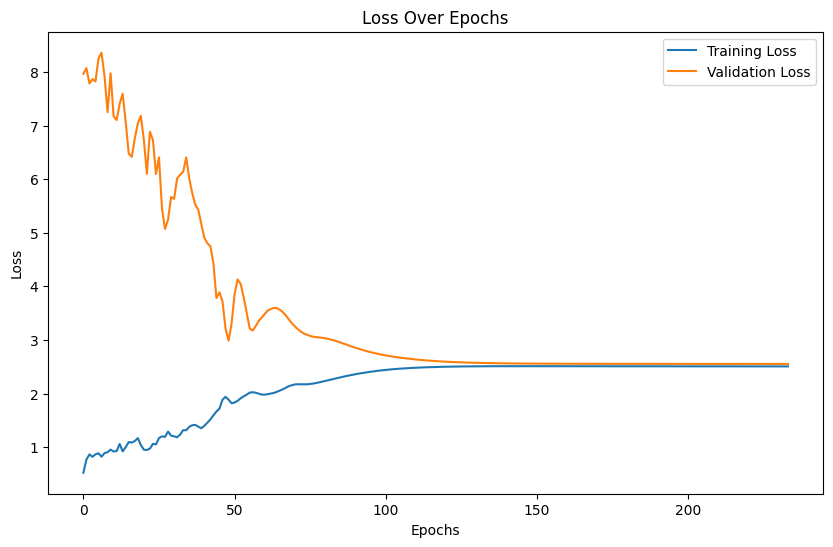

In [130]:
nn_relu.plot_loss(train_losses_relu, val_losses_relu)

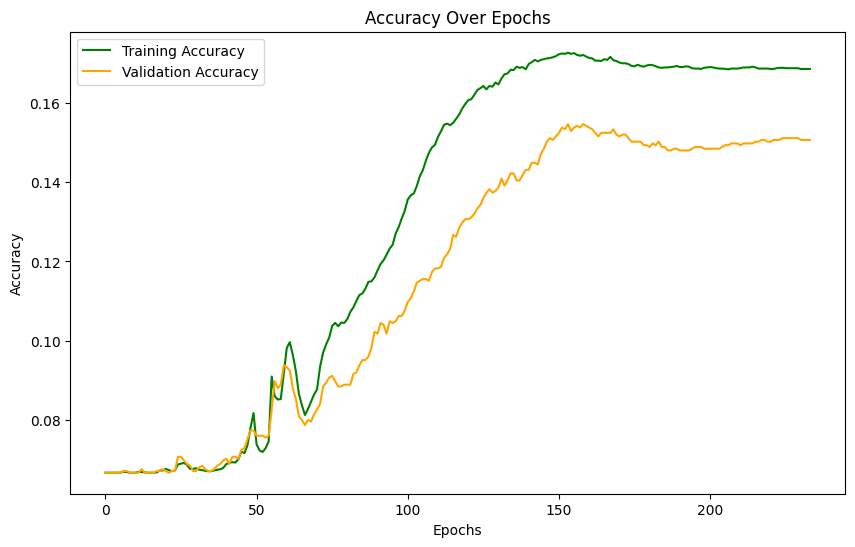

In [131]:
nn_relu.plot_accuracies(train_accuracies_relu, val_accuracies_relu)

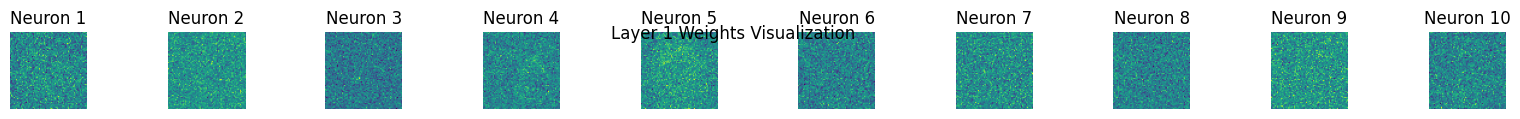

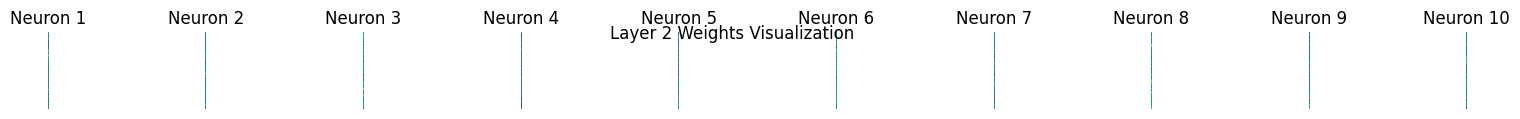

In [132]:
nn_relu.visualize_weights()


### Analysis:
> **Loss Metrics:** Across all models, the ReLU activation function shows the lowest training and validation loss, suggesting that it is slightly more effective in fitting the training data and generalizing to unseen data compared to other activation functions. The Leaky ReLU model also shows competitive performance in terms of training loss.

> **Accuracy Metrics:** In terms of training accuracy, the Leaky ReLU model leads, but its validation accuracy is the lowest. The ReLU model, while having slightly lower training accuracy compared to Leaky ReLU, shows the highest validation accuracy. This suggests that the ReLU model balances well between learning from the training data and generalizing to new, unseen data.

>**Overall Performance:** The model with the ReLU activation function appears to provide the best balance between training and validation performance. It manages to achieve the lowest loss on both training and validation sets and also scores the highest in validation accuracy, which is crucial for assessing the model's generalization capability.

>**Model Selection:** Given the above analysis, the ReLU model would be selected as the best performing model among the ones tested. It not only trains well but also generalizes better to unseen data compared to the other models.

### Saving Trained Neural Network Models

In [133]:
nn_relu.save_model('trained_nn_relu_model.pkl')
nn_tanh.save_model('trained_nn_tanh_model.pkl')
nn_sigmoid.save_model('trained_nn_sigmoid_model.pkl')
nn_leaky_relu.save_model('trained_nn_leaky_relu_model.pkl')

### Loading Trained Neural Network Models

In [134]:
nn_relu.load_model('trained_nn_relu_model.pkl')
nn_tanh.load_model('trained_nn_tanh_model.pkl')
nn_sigmoid.load_model('trained_nn_sigmoid_model.pkl')
nn_leaky_relu.load_model('trained_nn_leaky_relu_model.pkl')

## Performance Evaluations on Test Set

### ReLU

In [152]:
# Evaluate Performance for nn_relu
accuracy_relu, precision_relu, recall_relu, f1_relu = nn_relu.evaluate_performance(X_test, y_test)
print(f"Accuracy (ReLU): {accuracy_relu:.4f}\nPrecision: {precision_relu:.4f}\nRecall: {recall_relu:.4f}\nF1-Score: {f1_relu:.4f}")


Accuracy (ReLU): 0.1484
Precision: 0.1389
Recall: 0.1484
F1-Score: 0.1241


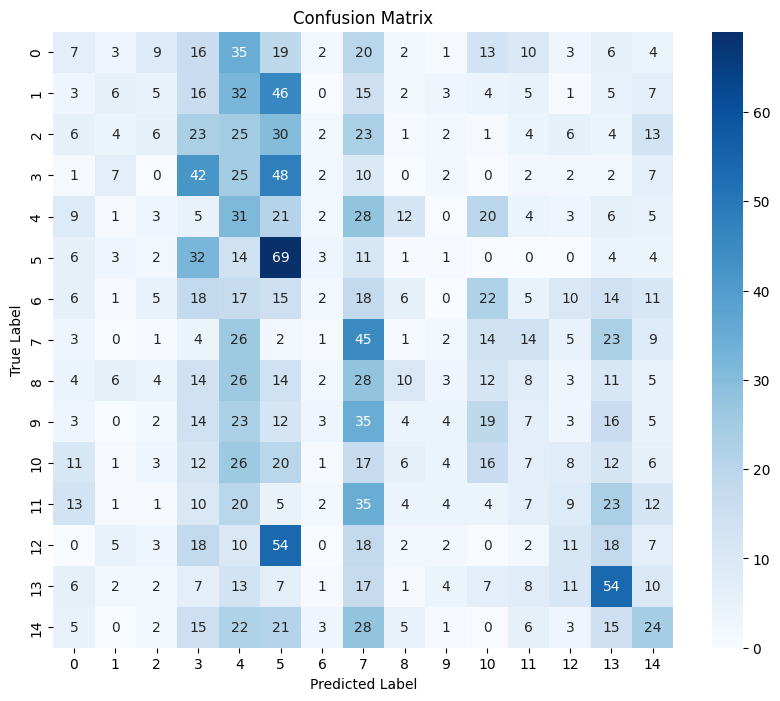

In [153]:
# Plot Confusion Matrix for nn_relu
conf_matrix_relu = nn_relu.plot_confusion_matrix(X_test, y_test)

### TANH

In [154]:
# Evaluate Performance for nn_tanh
accuracy_tanh, precision_tanh, recall_tanh, f1_tanh = nn_tanh.evaluate_performance(X_test, y_test)
print(f"Accuracy (Tanh): {accuracy_tanh:.4f}\nPrecision: {precision_tanh:.4f}\nRecall: {recall_tanh:.4f}\nF1-Score: {f1_tanh:.4f}")

Accuracy (Tanh): 0.1507
Precision: 0.1370
Recall: 0.1507
F1-Score: 0.1193


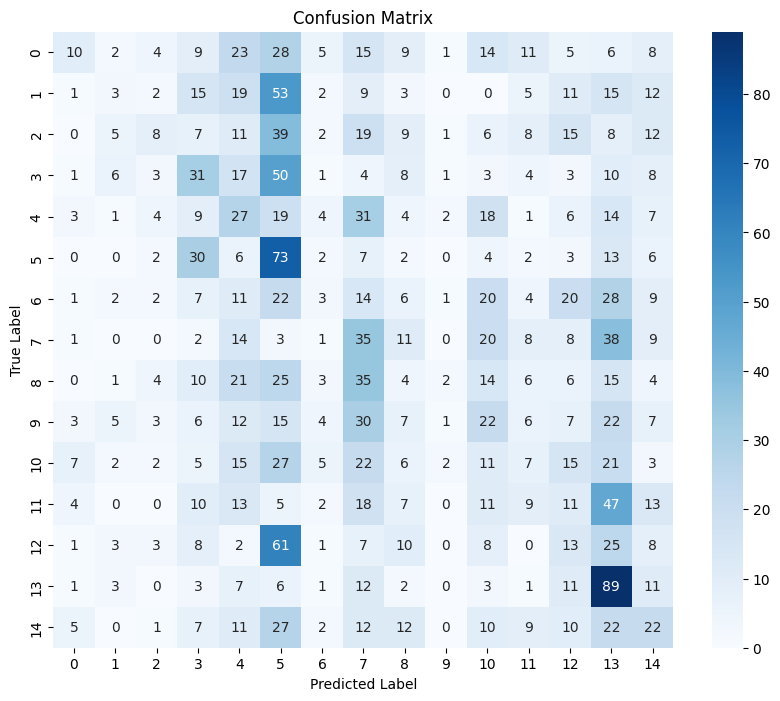

In [155]:
# Plot Confusion Matrix for nn_tanh
conf_matrix_tanh = nn_tanh.plot_confusion_matrix(X_test, y_test)

### SIGMOID

In [156]:
# Evaluate Performance for nn_sigmoid
accuracy_sigmoid, precision_sigmoid, recall_sigmoid, f1_sigmoid = nn_sigmoid.evaluate_performance(X_test, y_test)
print(f"Accuracy (Sigmoid): {accuracy_sigmoid:.4f}\nPrecision: {precision_sigmoid:.4f}\nRecall: {recall_sigmoid:.4f}\nF1-Score: {f1_sigmoid:.4f}")

Accuracy (Sigmoid): 0.1609
Precision: 0.1468
Recall: 0.1609
F1-Score: 0.1200


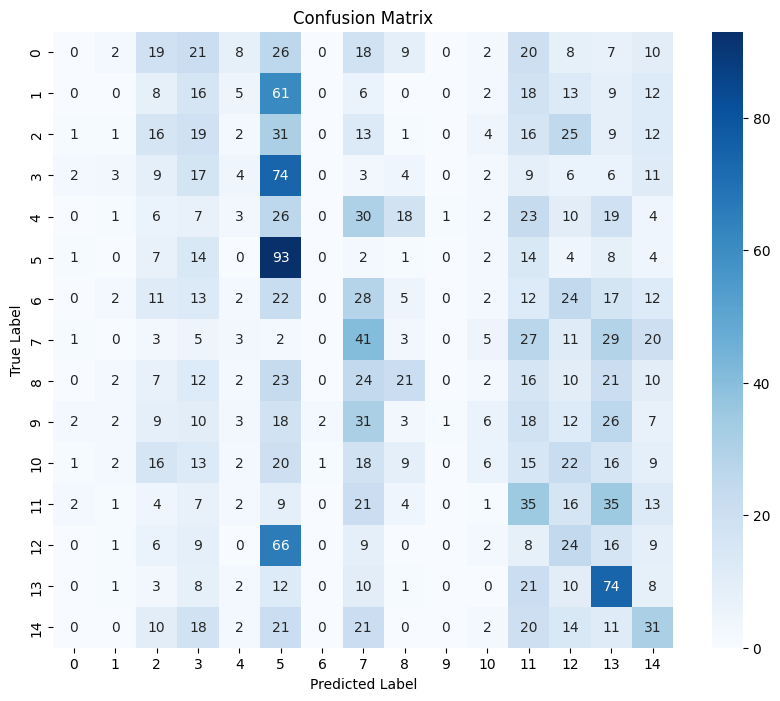

In [157]:
# Plot Confusion Matrix for nn_sigmoid
conf_matrix_sigmoid = nn_sigmoid.plot_confusion_matrix(X_test, y_test)

### LEAKY ReLU

In [158]:
# Evaluate Performance for nn_leaky_relu
accuracy_leaky_relu, precision_leaky_relu, recall_leaky_relu, f1_leaky_relu = nn_leaky_relu.evaluate_performance(X_test, y_test)
print(f"Accuracy (Leaky ReLU): {accuracy_leaky_relu:.4f}\nPrecision: {precision_leaky_relu:.4f}\nRecall: {recall_leaky_relu:.4f}\nF1-Score: {f1_leaky_relu:.4f}")


Accuracy (Leaky ReLU): 0.1600
Precision: 0.1424
Recall: 0.1600
F1-Score: 0.1277


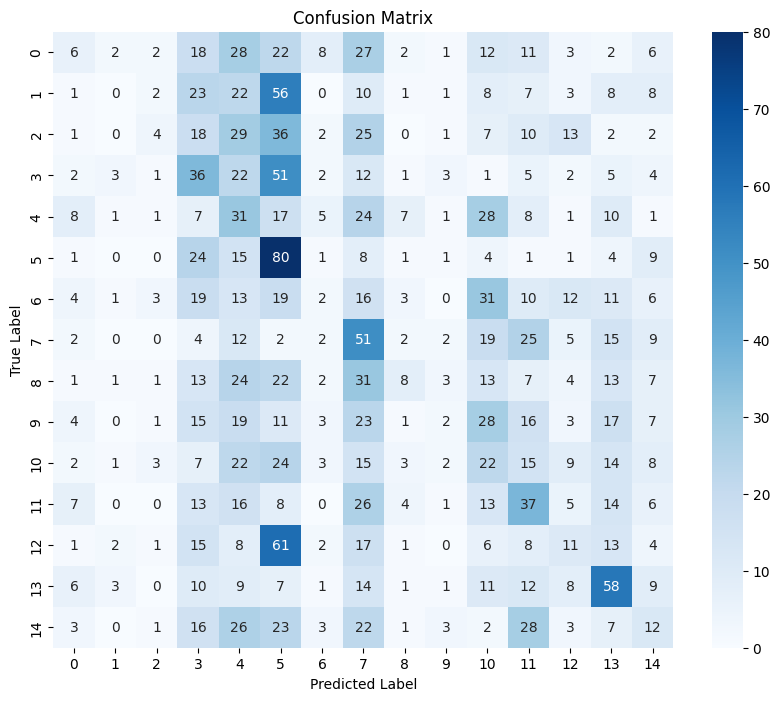

In [159]:
# Plot Confusion Matrix for nn_leaky_relu
conf_matrix_leaky_relu = nn_leaky_relu.plot_confusion_matrix(X_test, y_test)

## Neural Network Model Analysis


### Test Performance Evaluation

| Activation Function | Accuracy | Precision | Recall | F1-Score |
|---------------------|----------|-----------|--------|----------|
| ReLU                | 14.84%   | 13.89%    | 14.84% | 12.41%   |
| Sigmoid             | 16.09%   | 14.68%    | 16.09% | 12.00%   |
| Leaky ReLU          | 16.00%   | 14.24%    | 16.00% | 12.77%   |
| Tanh                | 15.07%   | 13.70%    | 15.07% | 11.93%   |

### Analysis and Comments

- **Overall Performance**: The Sigmoid and Leaky ReLU models exhibit slightly higher accuracy compared to the ReLU and Tanh models, suggesting better generalization to unseen data.

- **Precision and Recall**: Sigmoid and Leaky ReLU models lead in precision and recall. Higher recall in these models indicates better identification of relevant instances.

- **F1-Score**: The Leaky ReLU model shows the highest F1-Score, indicating a balanced performance between precision and recall, followed by the Sigmoid model.

- **Confusion Matrices**: Examination of the confusion matrices for each model reveals class-specific performance issues, indicating potential areas for improvement.

### Recommendation for the Best Model

- The **Leaky ReLU model** appears to offer the best overall balance among accuracy, precision, recall, and F1-Score. However, the differences between the models are relatively narrow.
